In [1]:
#Tratamiento de archivo .conllu
import pyconll as cnll

#Pandas para el lemmatizador (Evitamos diccionarios, son más lentos)
import pandas as pd

#CRF y varios para modelo TAGGER
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
import random

#REGEX para las funciones
import re

#PKL para los modelos
import pickle

In [2]:
conll = cnll.load_from_file('ancora_train.conllu')

In [3]:
frases = []#info de las frases + tokens
tokens = []#Cada token tiene TODA la info de sí mismo con respecto al resto (por frase)
for sentence in conll:
    frases.append(sentence)
    for token in sentence:
        tokens.append(token)
        
print('Frases:', len(frases), '\n','Palabras:', len(tokens))

#Esta primera parte sirve para crear un archivo diferente, el "superinfo", que tiene
#toda la info de las palabras del corpus

Frases: 14287 
 Palabras: 469366


# Lemmatizador

In [ ]:
lemmas = []
palabros = []
for sentence in conll:
    for token in sentence:
        #print(token.form, token.lemma)
        if token.form not in palabros:
            palabros.append(token.form)
            lemmas.append(token.lemma)
    
lemmatizador = pd.DataFrame()
lemmatizador['Form'] = palabros
lemmatizador['lemma'] = lemmas
with open('lemmatizador', 'wb') as files:
    pickle.dump(lemmatizador, files)

In [4]:
def lemmatizer(palabra):
    with open('lemmatizador' , 'rb') as f:
        rl = pickle.load(f)
    try:
        return rl[rl['Form']==palabra].iloc[0,1]
    except:
        return 'No lemma'

# TAGGER

In [5]:
#Crédito a David Moscoso por la función Camerino (https://github.com/dfmoscoso23)
def camerino(frase):
    with open('columnas', 'rb') as files:
        colum=pickle.load(files)
    df = pd.DataFrame(columns = ['Lemma', 'Punct','Mayus', 'Ultima', 'Primera',
                                 'Suf_sus', 'Suf_adj','Suf_ver','Suf_adv',
                                 'Afi_dim', 'Afi_aum', 'Afi_des'])
    frase = frase.split()
    for i in range(len(frase)):
        tupla = listalizador(frase,i)
        df.at[i,:] = tupla
    listas=[]
    for i in range(len(df)):
        conjunto=list(colum)
        lista_metible=[0 for x in range(len(colum))]
        if df.Lemma.iloc[i] in conjunto:
            indice=conjunto.index(df.Lemma.iloc[i])
            lista_metible[indice]=1
        for co in df.columns:
            if co in conjunto:
                indice=conjunto.index(co)
                lista_metible[indice]=df[co].iloc[i]
        listas.append(lista_metible)
        
    return listas

In [6]:
def listalizador(frase, indice):   
    palabra = frase[indice]
    puntuacion = (',','"',"'",'.',';',':','(',')','[',']','-','<','>','!','¡','?','¿','—')
    sustantivadores = ('ada', 'eda', 'ado', 'ero', 'aje', 'era', 'al', 'ismo', 'ar', 'ista',
                   'ato','azgo', 'azo', 'ancia', 'ez', 'encia','eza', 'dad', 'ismo',
                   'edad', 'ada', 'idad', 'itud', 'tad', 'or', 'ería', 'ada','era', 'ado',
                   'ición', 'aje', 'sión','ante', 'ido', 'ente' ,'amento', 'iente' ,'amiento'
                   'ción', 'imiento', 'ación','dor', 'ura')
    adjetivadores = ('al', 'iento', 'ienta', 'ario', 'aria', 'il', 'ero', 'era', 'ista',
                     'esco','esca','oso', 'osa', 'izo', 'iza','oide', 'able', 'ible',
                     'ante', 'dor','ente', 'iente', 'ivo', 'iva', 'or', 'ano', 'ana', 'ío')
    verbalizadores = ('ar', 'ear', 'ecer', 'izar', 'ar', 'ficar')
    aumentativos = ('ón', 'ona', 'azo', 'aza', 'ote', 'ota', 'udo', 'uda')
    diminutivos = ('ito', 'ita', 'ico', 'ica', 'illo', 'illa', 'ete', 'eta', 'ín', 'ina',
              'ejo', 'eja', 'uelo', 'huela')
    despectivo = ('aco', 'acho', 'acha', 'ajo', 'aja', 'ales', 'alla',
              'ángano', 'ángana', 'ango', 'anga', 'astre', 'astro',
              'astra', 'engue', 'ingo', 'ingue', 'orio', 'orrio',
              'orro', 'orra', 'uco', 'uca', 'ucho', 'ucha', 'ujo',
              'uja', 'ute', 'uza')       
    lista = []        
    lista.append(lemmatizer(palabra)) #LEMMA 
    lista.append(1 if palabra in puntuacion else 0) #es puntuacion
    lista.append(1 if palabra[0] == palabra[0].upper() else 0) #mayuscula
    lista.append(1 if indice == len(frase)-1 else 0) #es la última
    lista.append(1 if indice == 0 else 0) #es la primera
    
    
    if len(palabra)>3: 
        #ciclo sustantivos
        for i in range(2,8):
            if palabra[-i:] in sustantivadores: 
                lista.append(1)
                break
        if len(lista)<6:
            lista.append(0)
        #ciclo adjetivos
        for i in range(2,6):
            if palabra[-i:] in adjetivadores: 
                lista.append(1)
                break
        if len(lista)<7:
            lista.append(0)
        #ciclo verbos
        for i in range(2,6):
            if palabra[-i:] in verbalizadores: 
                lista.append(1)
                break
        if len(lista)<8:
            lista.append(0)
                       
        lista.append(1 if palabra[-5:] == 'mente' else 0)
       
    
        #ciclo diminutivos: generalmente sustantivos, también ADJ
        for i in range(2,6):
            if palabra[-i:] in diminutivos: 
                lista.append(1)
                break
        if len(lista)<10:
            lista.append(0)
        #ciclo aumentativos: generalmente sustantivos, también ADJ
        for i in range(2,4):
            if palabra[-i:] in aumentativos: 
                lista.append(1)
                break
        if len(lista)<11:
            lista.append(0)
        #ciclo despectivos: generalmente sustantivos, también ADJ
        for i in range(3,7):
            if palabra[-i:] in despectivo: 
                lista.append(1)
                break
        if len(lista)<12:
            lista.append(0)

    else:
        for i in range(7):
            lista.append(0)
        
        
    return tuple(lista)

In [7]:
def tagger(frase):
    with open('columnas', 'rb') as files:
        colum=pickle.load(files)
    dfiteo = pd.DataFrame(columns = colum)
    for i,k in enumerate(camerino(frase)):
        dfiteo.loc[i] = k
    with open('RF_all_model' , 'rb') as f:
        rf = pickle.load(f)
    return rf.predict(dfiteo)

# Training del tagger

In [8]:
# Corpus tratado (viene del ANCORA) con la info relevante, tarda un rato en crearse, 
# así que lo he adjuntado para que podáis echarle un ojo si queréis.
with open('superinfo' , 'rb') as f:
    rl = pickle.load(f)

#drop X, SYM, NUM
#drop INTJ cambiando los Sí por ADV
#replace PART por ADV
#IMPUTAR FALSE

#-DROPPING DE X, SYM, NUM
a = rl[rl['tagged']=='X'].index
b = rl[rl['tagged']=='SYM'].index
c = rl[rl['tagged']=='NUM'].index
lista = []
lista.extend(a)
lista.extend(b)
lista.extend(c)
rl.drop(lista,axis=0,inplace=True)
#-
#-REPLACE DE PART por ADV
rl. tagged = rl.tagged.str.replace('PART','ADV')
#-
#-DROPPING DE INTJ CON IMPUTACIÓN DE sí A ADV
aa = rl[rl['tagged']=='INTJ'].index.values
a = rl.loc[aa,'Lemma'][rl.loc[aa,'Lemma']!='sí'].index.values
rl.drop(a,axis=0,inplace=True)
a = rl[rl['tagged']=='INTJ'].index.values
rl.loc[a,'tagged'] = 'ADV'
#-
#-IMPUTACIÓN DE FALSES: 'DEL' Y 'AL' SON DET
a = rl[rl['Lemma']=='del'].tagged.index.values
b = rl[rl['Lemma']=='al'].tagged.index.values
lista = []
lista.extend(a)
lista.extend(b)
rl.loc[lista,'tagged'] = 'DET'
#-
#-IMPUTACIÓN DE FALSES: TODOS SON VERB
a = rl[rl.tagged.isna()].index.values
rl.loc[a,'tagged'] = 'VERB'
#-
#DROPPING DE PROPN
a = rl[rl['tagged']=='PROPN'].index.values
rl. drop(a, axis=0, inplace=True)
#-
#-IMPUTACION AUX como VERB
a = rl[rl['tagged']=='AUX'].index
rl.loc[a,'tagged'] = 'VERB'
#-
#prueba = rl.drop(['Lemma','Previo','Posterior'], axis=1)
#prueba = pd.concat([prueba, pd.get_dummies(rl['Lemma'])], axis=1)

a = rl[rl.duplicated()].index
rl.drop(a,axis=0,inplace=True)

In [9]:
%%time
prueba = rl.drop(['Lemma','Previo','Posterior'], axis=1)
prueba = pd.concat([prueba, pd.get_dummies(rl['Lemma'])], axis=1)

CPU times: user 19.9 s, sys: 4.02 s, total: 23.9 s
Wall time: 25.1 s


In [10]:
%%time
a = prueba.sample(100000)
print(a.tagged.value_counts())
from sklearn.model_selection import train_test_split
X,y = a.drop('tagged', axis=1), a['tagged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

NOUN     22474
DET      15101
VERB     14916
ADP      13409
ADJ      10030
PUNCT     9622
PRON      5791
ADV       3974
CCONJ     2801
SCONJ     1882
Name: tagged, dtype: int64
CPU times: user 17.9 s, sys: 5.68 s, total: 23.5 s
Wall time: 25.1 s


CPU times: user 47min 17s, sys: 47min 8s, total: 1h 34min 25s
Wall time: 32min 52s


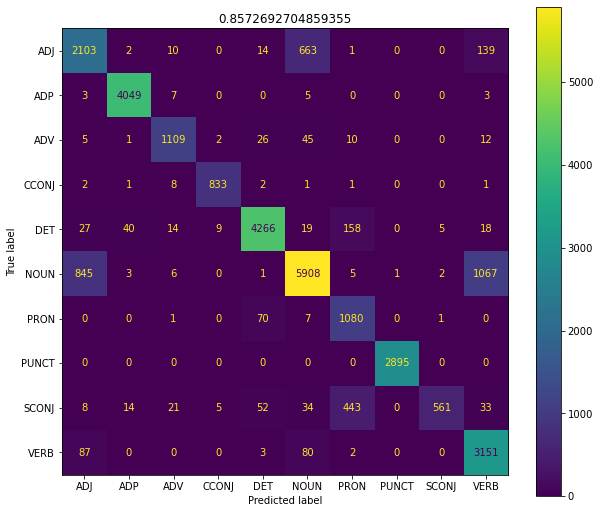

In [11]:
%%time
#MUESTRA Y GRAFICO (CON SAMPLING DE 100K)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

rf = RandomForestClassifier(criterion = 'entropy',
                           max_depth = 420,
                           max_leaf_nodes = 1260,
                           class_weight = 'balanced',
                            n_jobs=-1)
rf = rf.fit(X_train,y_train)

yhat = rf.predict(X_test)
cm = confusion_matrix(yhat, y_test) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
fig, ax = plt.subplots(figsize=(10,9))
plt.title(f1_score(yhat,y_test, average='macro'))
disp.plot(ax=ax)

In [ ]:
with open('RF_all_model', 'wb') as f:
    pickle.dump(rf, f)

In [13]:
tagger('voy a un estadio')

array(['VERB', 'ADP', 'DET', 'NOUN'], dtype=object)